# Exploratory Data Analysis (EDA) — spotify_history.csv

Fully executed notebook.

In [1]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline

DATA_PATH = r'/Users/ayanaaiken/Documents/SDC486L/archive/Spotify_history.csv'
df = pd.read_csv(DATA_PATH)
print('Dataset shape:', df.shape)
df.head(8)


Dataset shape: (149860, 11)


,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False
5,50VNvhzyaSplJCKWchN7a8,2013-07-08 03:17:52,web player,63485,Impossible,James Arthur,Impossible,clickrow,clickrow,False,False
6,1I4EczxGBcPR3J3KeyqFJP,2013-07-08 03:17:56,web player,0,We Own The Sky,M83,Saturdays = Youth,nextbtn,nextbtn,False,False
7,5arVt2Wg0zbiWwAOZef2Nl,2013-07-08 03:17:56,web player,1268,Higher Ground - Remastered 2003,Red Hot Chili Peppers,Mother's Milk,nextbtn,nextbtn,False,False


In [2]:

# dtypes and missing overview
dtypes = df.dtypes.to_frame('dtype')
missing = df.isna().sum().to_frame('missing_count')
missing['missing_pct'] = 100 * missing['missing_count'] / df.shape[0]
print('--- dtypes ---')
display(dtypes)
print('\n--- missing (top 20) ---')
display(missing.sort_values('missing_pct', ascending=False).head(20))


--- dtypes ---


,dtype
spotify_track_uri,object
ts,object
platform,object
ms_played,int64
track_name,object
artist_name,object
album_name,object
reason_start,object
reason_end,object
shuffle,bool



--- missing (top 20) ---


,missing_count,missing_pct
reason_start,143,0.095422
reason_end,117,0.078073
spotify_track_uri,0,0.000000
platform,0,0.000000
ts,0,0.000000
ms_played,0,0.000000
track_name,0,0.000000
album_name,0,0.000000
artist_name,0,0.000000
shuffle,0,0.000000


In [3]:
df['track_name'] = df['track_name'].fillna("Unknown")
df['reason_end']= df['reason_end'].fillna(df['reason_end'].mode()[0])
df['reason_start'] = df['reason_start'].fillna(df['reason_start'].mode()[0])
display(df.isnull().sum())

spotify_track_uri    0
ts                   0
platform             0
ms_played            0
track_name           0
artist_name          0
album_name           0
reason_start         0
reason_end           0
shuffle              0
skipped              0
dtype: int64

In [4]:

# Try coercing numeric-like object columns to numeric where reasonable
for c in df.columns:
    if df[c].dtype == 'object':
        coerced = pd.to_numeric(df[c].str.replace(r'[^0-9.+-]', '', regex=True), errors='coerce')
        if coerced.notna().sum() > df.shape[0] * 0.1:
            df[c] = coerced

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print('Numeric columns detected:', numeric_cols)
print('Categorical columns (sample):', cat_cols[:10])


Numeric columns detected: ['spotify_track_uri', 'ms_played', 'track_name']
Categorical columns (sample): ['ts', 'platform', 'artist_name', 'album_name', 'reason_start', 'reason_end']


In [5]:

# Summary stats for numeric columns
if len(numeric_cols) > 0:
    summary_stats = df[numeric_cols].describe().transpose()
    display(summary_stats)
else:
    print('No numeric columns for summary.')


,count,mean,std,min,25%,50%,75%,max
spotify_track_uri,149860.0,5.791662e+07,8.296352e+09,0.000000e+00,476.0,5859.0,76449.0,3.177790e+12
ms_played,149860.0,1.283166e+05,1.178401e+05,0.000000e+00,2795.0,138840.0,218507.0,1.561125e+06
track_name,25733.0,-9.047513e+05,1.024388e+08,-1.161992e+10,-2010.0,-2009.0,-2009.0,1.042104e+07


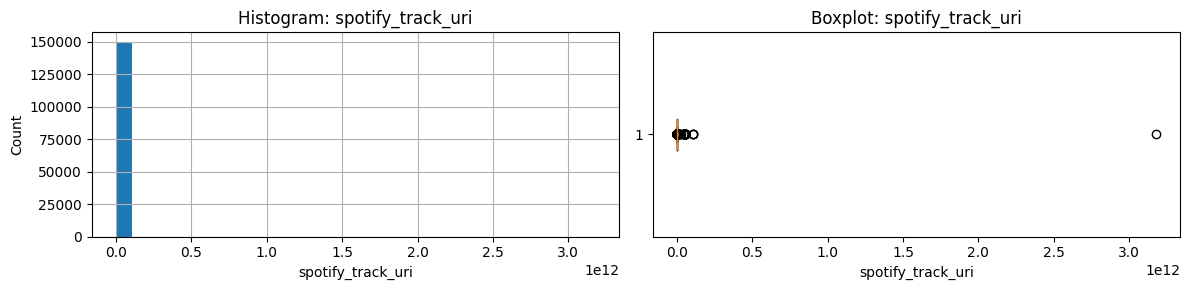

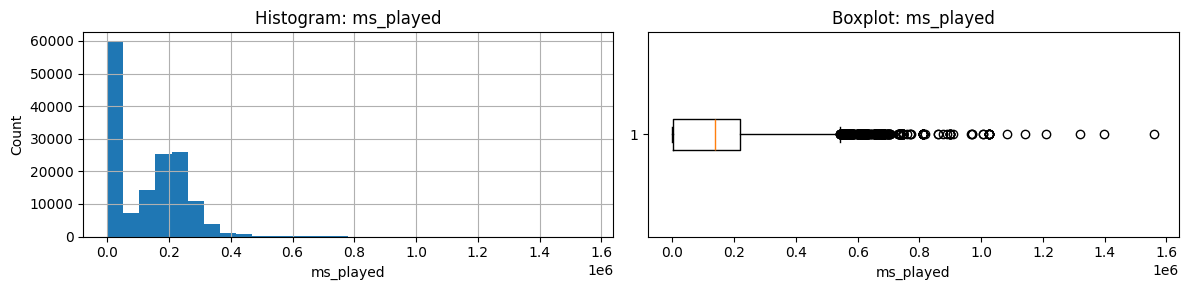

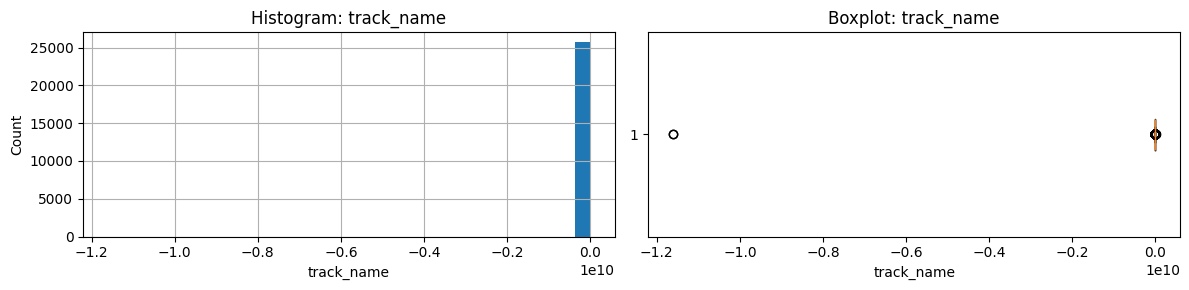

In [6]:

# Histograms and boxplots for numeric columns
if len(numeric_cols) == 0:
    print('No numeric columns to plot.')
else:
    for col in numeric_cols:
        fig, ax = plt.subplots(1,2, figsize=(12,3))
        df[col].dropna().hist(bins=30, ax=ax[0])
        ax[0].set_title(f'Histogram: {col}')
        ax[0].set_xlabel(col); ax[0].set_ylabel('Count')
        ax[1].boxplot(df[col].dropna(), vert=False)
        ax[1].set_title(f'Boxplot: {col}'); ax[1].set_xlabel(col)
        plt.tight_layout(); plt.show()


Correlation matrix:


,spotify_track_uri,ms_played,track_name
spotify_track_uri,1.000000,-0.001745,0.001133
ms_played,-0.001745,1.000000,-0.010179
track_name,0.001133,-0.010179,1.000000


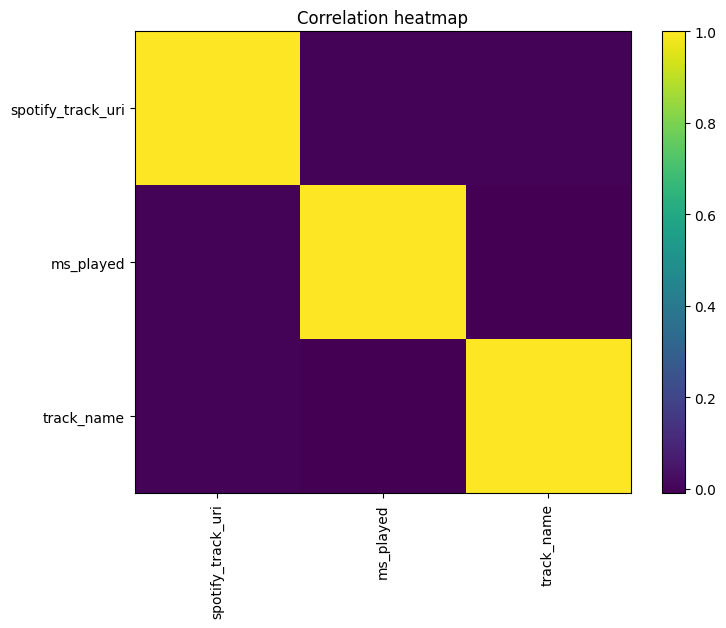

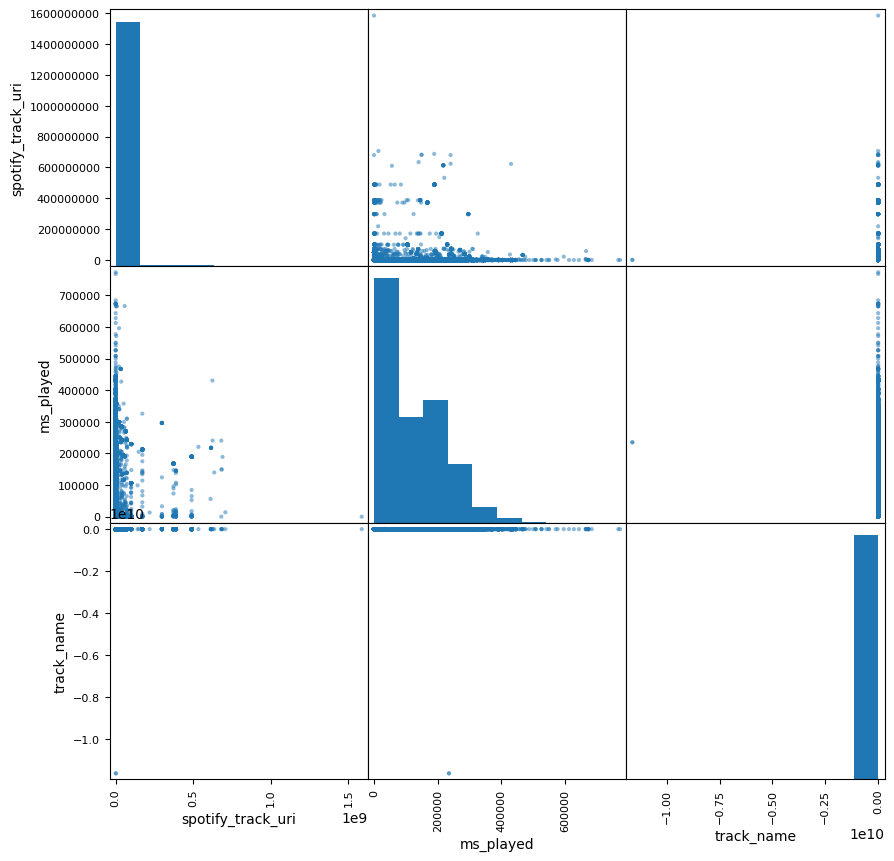

In [7]:

# Correlation and pairwise plots if applicable
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    print('Correlation matrix:'); display(corr)
    plt.figure(figsize=(8,6)); plt.imshow(corr.values, interpolation='nearest', aspect='auto'); plt.colorbar()
    ticks = range(len(corr.columns)); plt.xticks(ticks, corr.columns, rotation=90); plt.yticks(ticks, corr.columns)
    plt.title('Correlation heatmap'); plt.show()
    pair_cols = numeric_cols[:6]
    _ = scatter_matrix(df[pair_cols].dropna(), figsize=(10,10), diagonal='hist')
else:
    print('Not enough numeric columns for correlation/pairwise plots.')


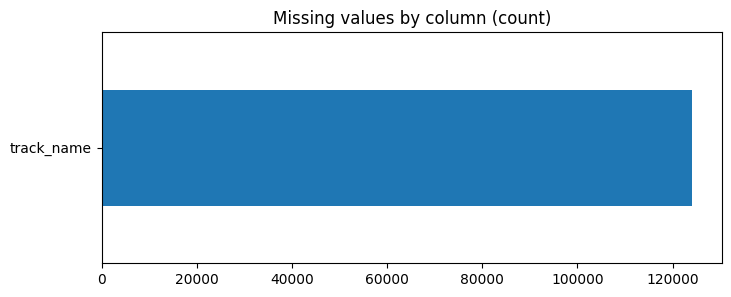

In [8]:

# Missing values bar chart
mv = df.isna().sum()
mv = mv[mv > 0].sort_values(ascending=False)
if len(mv) > 0:
    plt.figure(figsize=(8, max(3, len(mv)*0.25)))
    mv.plot.barh(); plt.title('Missing values by column (count)'); plt.show()
else:
    print('No missing values.')


In [9]:

# Preprocessing pipeline on a safe sample (to avoid extreme memory use with OHE)
sample = df.copy().iloc[:2000].reset_index(drop=True)
num_cols = [c for c in numeric_cols if c in sample.columns]
cat_cols = [c for c in cat_cols if c in sample.columns]

print('Sample size:', sample.shape)
print('Numeric columns for preprocessing:', num_cols)
print('Categorical columns for preprocessing (sample):', cat_cols[:10])

from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_cols), ('cat', cat_pipeline, cat_cols)], remainder='drop')

if len(num_cols)+len(cat_cols) > 0:
    X_trans = preprocessor.fit_transform(sample)
    print('Transformed sample shape:', X_trans.shape)
else:
    print('No columns to transform.')


Sample size: (2000, 11)
Numeric columns for preprocessing: ['spotify_track_uri', 'ms_played', 'track_name']
Categorical columns for preprocessing (sample): ['ts', 'platform', 'artist_name', 'album_name', 'reason_start', 'reason_end']


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [ ]:

# PCA inspection
from sklearn.decomposition import PCA
if 'X_trans' in globals() and X_trans is not None and X_trans.shape[1] > 1:
    n_comp = min(10, X_trans.shape[1])
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_trans)
    ev = pca.explained_variance_ratio_
    print('Explained variance ratio:', ev)
    print('Cumulative explained variance:', ev.cumsum())
else:
    print('PCA not applicable.')


PCA not applicable.


In [ ]:

# Heuristic target detection and small baseline
potential_targets = [c for c in df.columns if any(k in c.lower() for k in ['msplayed','duration','played','count','listen','popularity'])]
print('Potential targets:', potential_targets)
target = potential_targets[0] if len(potential_targets) > 0 else None

if target and target in df.columns and df[target].dtype.kind in 'biufc':
    print('Using target:', target)
    tmp = df[[target] + [c for c in numeric_cols + cat_cols if c != target]].dropna().sample(frac=1, random_state=42).reset_index(drop=True)
    tmp = tmp.iloc[:2000]
    X = tmp.drop(columns=[target]); y = tmp[target]
    num_present = [c for c in numeric_cols if c in X.columns]
    cat_present = [c for c in cat_cols if c in X.columns]
    coltr = ColumnTransformer(transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_present),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))]), cat_present)
    ], remainder='drop')
    X_proc = coltr.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, random_state=42)
    dummy = DummyRegressor(strategy='mean'); dummy.fit(X_train, y_train)
    print('Dummy R^2:', dummy.score(X_test, y_test))
    rf = RandomForestRegressor(n_estimators=50, random_state=42); rf.fit(X_train, y_train)
    print('RandomForest R^2 (50 trees):', rf.score(X_test, y_test))
else:
    print('No suitable numeric target identified for baseline.')


Potential targets: ['ms_played']
Using target: ms_played


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [10]:

# Save outputs: summary stats and missing values to OUT_DIR
OUT_DIR = r'/Users/AyanaAiken/Documents/SDC486L/archive'
clean_df = r'/Users/AyanaAiken/Documents/SDC486L/archive'
import os
os.makedirs(OUT_DIR, exist_ok=True)
if len(numeric_cols) > 0:
    pd.DataFrame(df[numeric_cols].describe().transpose()).to_csv(os.path.join(OUT_DIR, 'summary_stats_numeric.csv'))
    pd.DataFrame(df.isna().sum().to_frame('missing_count')).to_csv(os.path.join(OUT_DIR, 'missing_values_report.csv'))
print('Saved summary files to', OUT_DIR)
df = df.to_csv(os.path.join(clean_df, "clean_dataframe.csv"))
print("Saved clean data to Archive directory.")

Saved summary files to /Users/AyanaAiken/Documents/SDC486L/archive
Saved clean data to Archive directory.


In [7]:
import pandas as pd

data ='/Users/ayanaaiken/Documents/SDC486L/archive/clean_dataframe.csv'
df2 = pd.read_csv(data)
df2.isnull().sum()


Unnamed: 0                0
spotify_track_uri         0
ts                        0
platform                  0
ms_played                 0
track_name           124127
artist_name               0
album_name                0
reason_start              0
reason_end                0
shuffle                   0
skipped                   0
dtype: int64